In [10]:
import numpy as np 
import math 
import numpy.random as npr
import matplotlib.pyplot as plt 
import scipy.stats as stats 
from tqdm import tqdm
from scipy.integrate import quad
np.random.seed(1234)

## Notations 

Toutes les variables aléatoires sont définies sur un espace de probabilité $ (\Omega, \mathcal{F}, \mathbb{P}) $ et prennent leurs valeurs dans un espace mesurable $ \mathbb{X} $ qui est $ \mathbb{Z} $ ou $ \mathbb{R} ^d $. 

- $ X \sim p $ : $X $ admet une densité par rapport à la mesure de Lebesgue ou de comptage. 

- $ Y \sim q $

- $ \frac{ d \mathbb{P} _{(X,Y)}}{d \lambda} := \Gamma $

- $ U_n \sim V_n $ ssi $ \frac{U_n}{V_n} \to 1 $ quand $n \to + \infty $

## Plan 

- Introduction 

- Méthode d'échantillonnage par rejet couplé

## Introduction 

Si $(X_t)_t$ et $(Y_t)_t$ sont des chaînes de Markov, le temps de couplage est défini comme : $\text{inf} \{t \ge 0 : X_t = Y_t \}$. 

On propose une illustration à partir de [l'article](https://proceedings.mlr.press/v130/wang21d/wang21d.pdf) de O’Leary, Wang et Jacob. 

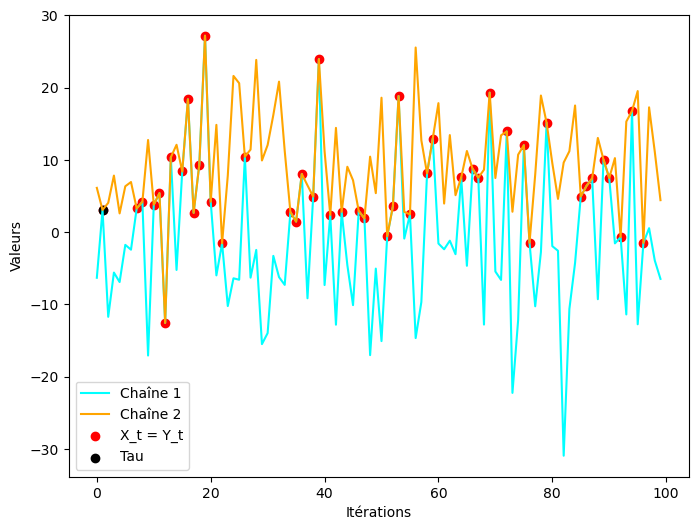

In [3]:
def algorithm2(values, length):
    def normal_mean(value, evaluate):
        """  Densité d'une loi normale de moyenne value et de variance 10, évaluée en evaluate      
        """
        return np.exp(-(evaluate - value)**2 / 20) / (np.sqrt(20 * np.pi))
    simulation = []

    for i in range(length):
        x2, U = npr.normal(values[0], 10), npr.uniform()
        rapport = normal_mean(values[1], x2) / normal_mean(values[0], x2)
        if U <= rapport: 
            y2 = x2
        else: 
            repeat = True 
            while repeat: 
                y3, V = npr.normal(values[1], 10), npr.uniform()
                rapport = normal_mean(values[0], y3) / normal_mean(values[1], y3)
                if rapport <= V: 
                    y2 = y3
                    repeat = False
        simulation.append([i, x2, y2])
    return np.array(simulation) 

simulation = algorithm2(np.array([0.25, 4]), 10**2)
plt.figure(figsize=(8,6))
plt.plot(simulation[:,0], simulation[:,1], label = "Chaîne 1", color = "cyan")
plt.plot(simulation[:,0], simulation[:,2], label = "Chaîne 2", color = 'orange')
plt.scatter(simulation[simulation[:,1] == simulation[:,2]][:,0], simulation[simulation[:,1] == simulation[:,2]][:,1], color='red', label="X_t = Y_t")
plt.scatter(simulation[simulation[:,1] == simulation[:,2]][0,0],simulation[simulation[:,1] == simulation[:,2]][0,1], color='black', label="Tau")
plt.plot()
plt.xlabel("Itérations")
plt.ylabel("Valeurs")
plt.legend()
plt.show()

## Méthode d'échantillonnage par rejet couplé

$\textbf{Definition 1}$ : Un couple de variables aléatoires $ (X, Y)$ défini sur le même espace de probabilité et prenant ses valeurs dans $ \mathcal{X} $ est un couplage diagonal de probabilités $p$ et $q$ si, et seulement si, c'est un couplage tel que : 

- $ \mathbb{P} (X \in A) = \displaystyle \int _{A} p(x) dx $ 

- $ \mathbb{P} (Y \in A) = \displaystyle \int _{A} q(x) dx $, $ \forall A \subset \mathcal{X}$ 

- $ \mathbb{P} (X = Y) > 0$

Avec cette définition, un couplage maximal est un couplage diagonal de masse maximale sur l'évènement $ \{ X = Y \}$. 


$\textbf{Definition 2}$ : Soient $( \hat{p}, \hat{q}) $ une paire de densités de probabilité. On dit que $( \hat{p}, \hat{q}) $ domine $ (p,q) $ ou on écrit $( \hat{p}, \hat{q}) \succeq ( \hat{p}, \hat{q}) $ ssi il existe $ 1 \le M(p, \hat{p}) < + \infty$ , $ 1 \le M(q, \hat{q}) < + \infty$ tel que $ \forall x \in \mathbb{R} ^d$ on ait : $ p(x) \le M(p, \hat{p}) \hat{p} (x) $ , $ q(x) \le M(q, \hat{q}) \hat{q} (x) $.

Attention ! Ce n'est pas parce que nous avons de tels $( \hat{p}, \hat{q}) \succeq ( \hat{p}, \hat{q}) $ que $ \hat{ \Gamma } \succeq \Gamma $. 


Supposons que nous disposons de tels $( \hat{p}, \hat{q}) \succeq ( \hat{p}, \hat{q}) $ et de  $\hat{ \Gamma } \succeq \Gamma $. Nous pouvons alors proposer l'allgorithme suivant :



In [2]:
def RejectionCoupling(p, q, p_hat, q_hat, M):
    """  Rejection Coupling (Algorithm1)
    GammaH (H pour Hat) représentant le couplage définit plus haut 
    """

    AX, AY = 0, 0
    while AX == 0 & AY == 0: 
        X1, Y1 = p, q
        U = npr.uniform()
        if U < (p(X1)) /  (p_hat(X1)* M(p(X1),p_hat(X1))):
            AX = 1
        if U < (q(Y1)) /  (q_hat(Y1)* M(q(Y1),q_hat(Y1))):
            AY = 1
    X2, Y2 = (p*q).rvs()
    return AX * X1 + (1-AX) * X2, AY * Y1 + (1-AY) * Y2

In [3]:
mu, eta = 0.9, 0.8

def alpha(x):
    return((x + math.sqrt(x**2 + 4))/2)

def ratio(x, m):
    return(np.exp(-(x-alpha(m))**2)/2)

Exemple : 

$ X, Y \sim \mathcal{U} ([0,3] \times [0,2]) $ et $ W, Z \sim \mathcal{U} ([0,1] ^2) $ où $X, Y, Z, W $ sont i.i.d. 

## Application 1 : Liaison des queues des distributions gaussiennes

Soient $X \sim \mathcal{N}(0,1), Y \sim \mathcal{N}(0,1)$.

Introduisons $X_{\mu} = X | X > \mu$ de densité par rapport à la mesure de lebesgue $ p_{\mu}$ et $Y_{\eta} = Y | Y > \eta$ de densité par rapport à la mesure de lebesgue $ q_{\eta}$.

Lorsque $\mu , \eta $ deviennent grand, on ne peut plus utliser la méthode d'inversion pour simuler $p$ et $q$, nous devons voir recours à la méthode d'échantillonnage par rejet. 

On utilise une loi exponentielle translatée comme proposition : $\text{Exp} (x; m, \lambda) = \lambda e^{- \lambda (x-m)} \textbf{1} (x \ge m)$.

Sans pertes de généralités, on suppose que $ \eta > \mu $.

In [4]:
mu, eta = 0.9, 0.8

def RejectionCouplingExample1(mean, cov):
    """  Rejection Coupling (Algorithm1)
    GammaH (H pour Hat) représentant le couplage définit plus haut 
    """
    def ratio(x, m):
        return(np.exp(-(x-alpha(m))**2)/2)
    
    def alpha(x):
        return((x + math.sqrt(x**2 + 4))/2)

    AX, AY = 0, 0
    while AX == 0 & AY == 0: 
        X1, Y1 = stats.expon.rvs(loc=mu,scale = 1/alpha(mu)),stats.expon.rvs(loc=eta,scale = 1/alpha(eta))
        U = npr.uniform()
        if U < ratio(X1, mu):
            AX = 1
        if U < ratio(Y1, eta):
            AY = 1
    X2, Y2 = np.random.multivariate_normal(mean, cov)
    return AX * X1 + (1-AX) * X2, AY * Y1 + (1-AY) * Y2

In [5]:
mean = np.array([0,0])
cov = np.array([[1,0], [0,1]])
RejectionCouplingExample1(mean, cov)

(1.6235541209150934, 1.6224796430693722)

In [6]:
samples = 100000
X,Y =[],[]
for i in tqdm(range(samples)):
    x,y = RejectionCouplingExample1(mean,cov)
    prob = np.sum(x==y)

prob
# Aie, ça fonctionne pas 

100%|██████████| 100000/100000 [00:20<00:00, 4894.52it/s]


0

In [9]:
def RejectionCouplingEx1_test2(p_hat, q_hat,mu,eta):
    x = np.linspace(max(mu, eta), 10, 100)
    U = np.random.uniform(0,1)
    def min_pdf(x, p_hat, q_hat):
        return min(p_hat(x), q_hat(x))
    integral, _ = quad(min_pdf, max(mu, eta), np.inf, args=(p_hat, q_hat))

    if U <= integral:
        X = min(p_hat,q_hat)/integral
        Y = X
    else:
        integrand_p = lambda x: p_hat(x) - min(p_hat(x), q_hat(x))
        integrand_q = lambda x: q_hat(x) - min(p_hat(x), q_hat(x))

        integral_p, _ = quad(integrand_p, mu, np.inf)
        integral_q, _ = quad(integrand_q, eta, np.inf)

        X = p_hat - min(p_hat, q_hat) / integral_p
        Y = q_hat - min(p_hat, q_hat) / integral_q
    return X, Y

#p_hat = stats.expon.pdf(x,loc = mu,scale = 1/alpha(mu))
#q_hat = stats.expon.pdf(x,loc = eta,scale = 1/alpha(eta))
x = np.linspace(max(mu, eta), 10, 100)
p_hat = lambda x: stats.expon.pdf(x, loc=mu, scale=1/alpha(mu))
q_hat = lambda x: stats.expon.pdf(x, loc=eta, scale=1/alpha(eta))

RejectionCouplingEx1_test2(p_hat,q_hat,mu,eta)

TypeError: '<' not supported between instances of 'function' and 'function'

## Algorithme de Thorisson 

In [2]:
def ThorissonCoupling(p, q, C):
    X = p.rvs()
    U = np.random.uniform()
    if U < min(q.pdf(X) / p.pdf(X), C): 
        Y = X
    else: 
        A = 0
        while A!=1: 
            U = np.random.uniform()
            Z = q.rvs()
            if U > min(1, C * (p.pdf(Z) / q.pdf(Z))):
                A = 1
            Y = Z
    return X,Y

100%|██████████| 10000/10000 [00:10<00:00, 957.04it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


La probabilité que X=Y vaut : 0.122


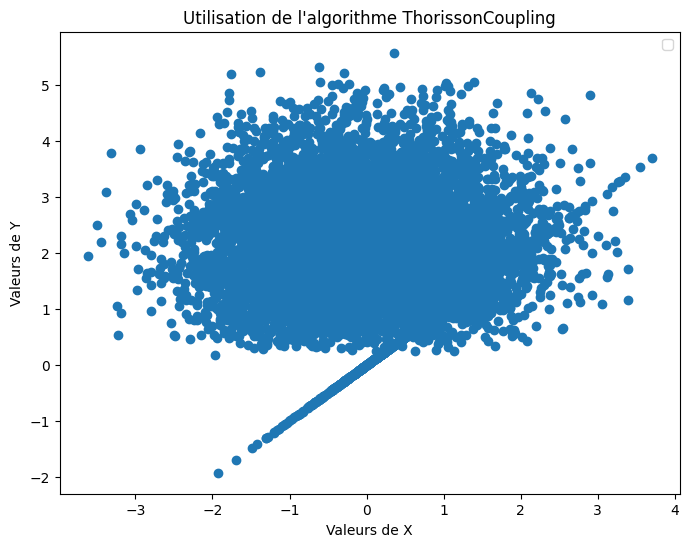

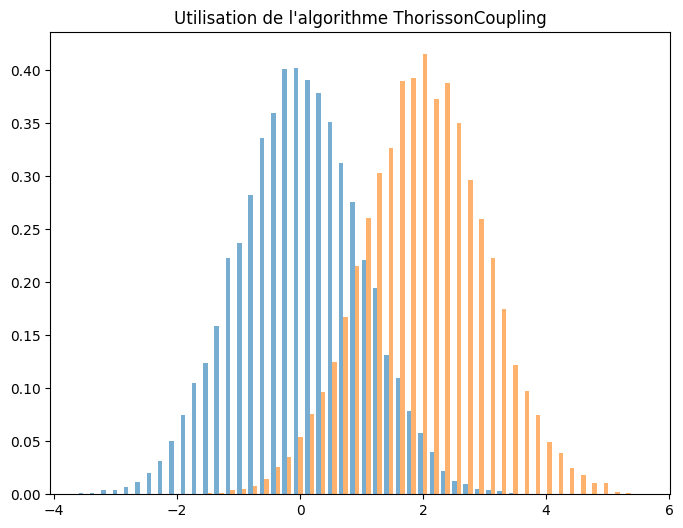

In [11]:
n = 10**4
C = np.random.uniform()
couple = []
for _ in tqdm(range(n)):
    p = stats.norm(0, 1)  
    q = stats.norm(2, 1)  
    couple.append(ThorissonCoupling(p, q, C))

couple = np.array(couple)
print("La probabilité que X=Y vaut :", np.sum(couple[:,0]==couple[:,1]) / len(couple))
plt.figure(figsize=(8,6))
plt.scatter(couple[:,0], couple[:,1])
plt.xlabel("Valeurs de X")
plt.ylabel("Valeurs de Y")
plt.title('Utilisation de l\'algorithme ThorissonCoupling')
plt.legend()
plt.show()
plt.figure(figsize=(8,6))
plt.hist(couple, bins=50, density=True, alpha=0.6)
plt.title('Utilisation de l\'algorithme ThorissonCoupling')
plt.show()

Cette approche est valide pour construire une distribution jointe (couplage) pour $(X,Y) $ telle que $ X \sim p$, $Y \sim q$ et $ \mathbb{P} (X=Y) $ avec une probabilité élevée, et elle est liée à l'échantillonnage par rejet.

L'algorithme de Thorisson Coupling utilise l'idée de l'échantillonnage par rejet pour construire une distribution jointe pour 
$(X,Y)$. 

- On tire un échantillon $X$ selon la distribution $p$ et $U \sim \mathcal{U} ( (0,1))$. 

- On regarde si $U$ est inférieur à un certain seuil déterminé par rapport aux densités de probabilité $p$ et $q$. 
